# Mapping sensor level measurements to source level brain activity

The SEEG data is modeled by $S(t)=GX(t)$, where $S \in\mathbb{R}^{ns \times nt}$ is sensor-level SEEG measurements at time $t$, and $G \in\mathbb{R}^{ns \times nn}$ is gain (lead-field or projection) matrix. The source brain activity $X \in\mathbb{R}^{nn \times nt}$ rendering as a non-linear function of hidden states given by Epileptor model. Here, we aim to estimate the hidden source brain activity $X(t)$ by Moore-Penrose inversion of the known gain matrix $G$, and compared it with two implementations of source estimation in Stan.

$nn$: number of brain regions,

$ns$: number of sensors, 

$nt$: number of data points per sensor.



In [1]:
import os
import re
import sys
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from mpl_toolkits.mplot3d import Axes3D

In [3]:
from numpy.linalg import matrix_rank

In [4]:
import seaborn as sns
sns.set_style("white")
sns.set_context("talk")

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [5]:
cwd = os.getcwd()
cwd

'/data/ProbabilisticSourceLocalization'

Here, we load the simulated data (TVB output).

In [6]:
synthetic_data=np.load(cwd+'/data_input_files/TVBsimulatedSEEG_Epileptor6D.npz')

In [7]:
G=synthetic_data['Gain']
X_true=synthetic_data['LFP_true']
Z_true=synthetic_data['Z_true']
Ez_idx=synthetic_data['Ez_idx']
Pz_idx=synthetic_data['Pz_idx']

In [8]:
G.shape, X_true.shape

((162, 84), (84, 1200))

In [9]:
Seeg=np.dot(G, X_true)
Seeg.shape

(162, 1200)

ns: total number of sensors

ns: total number of regions (nodes)

nt: total number of recording times


In [10]:
nt=int(Seeg.shape[1])
ns=int(G.shape[0])
nn=int(G.shape[1])

In [11]:
nn, ns, nt

(84, 162, 1200)

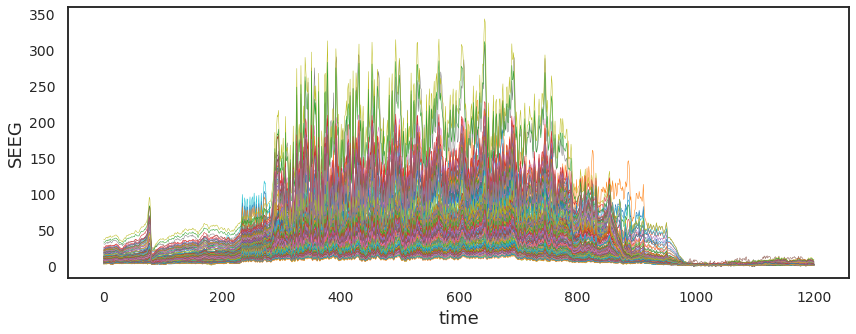

In [12]:
plt.figure(figsize=(14, 5))
for i in range(ns):
    plt.plot(Seeg[i, :]-min(Seeg[i, :]), lw=0.5)
plt.xlabel("time", fontsize=18)
plt.ylabel("SEEG", fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig(os.path.join(cwd+'/Figs',"SimulatedSeeg.png"))
plt.show() 

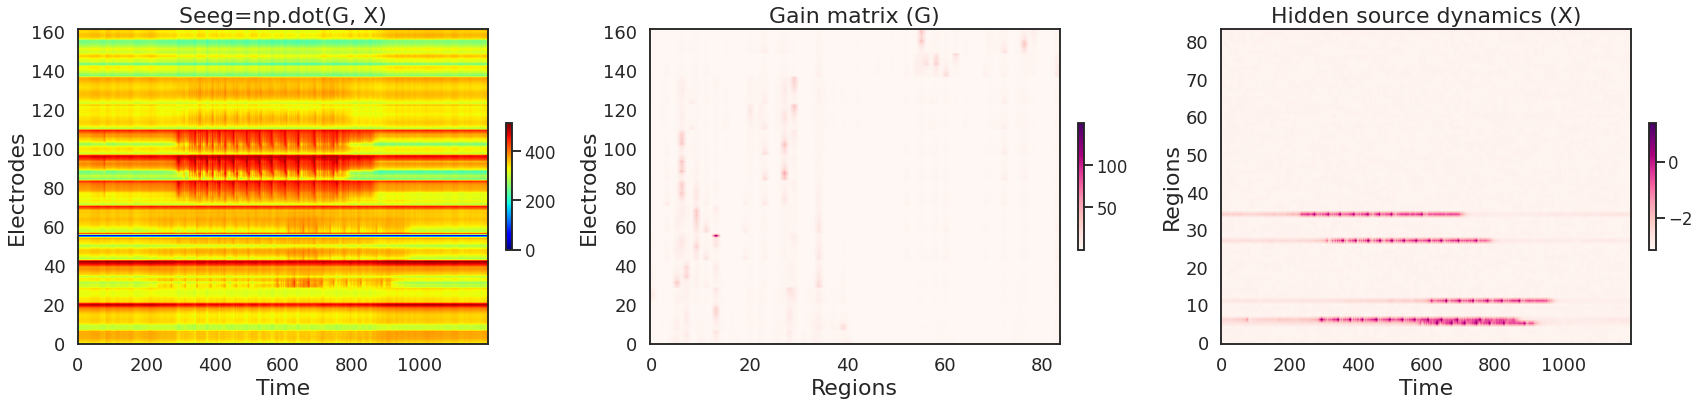

In [13]:
plt.figure(figsize=(24, 6))
plt.subplot(131);
plt.imshow(Seeg-np.min(Seeg, axis=0), aspect='auto', interpolation='bilinear',  origin='lower', cmap='jet')
plt.colorbar(fraction=0.046, pad=0.04, shrink=0.4)
plt.title("Seeg=np.dot(G, X)", fontsize=22) 
plt.xlabel('Time', fontsize=22)
plt.ylabel('Electrodes', fontsize=22)
plt.yticks(fontsize=18, rotation=0)
plt.xticks(fontsize=18, rotation=0)

plt.subplot(132);
plt.imshow(G, aspect='auto', interpolation='bilinear',  origin='lower', cmap='RdPu')
plt.colorbar(fraction=0.046, pad=0.04, shrink=0.4)
plt.title("Gain matrix (G)", fontsize=22) 
plt.xlabel('Regions', fontsize=22)
plt.ylabel('Electrodes', fontsize=22)
plt.yticks(fontsize=18, rotation=0)
plt.xticks(fontsize=18, rotation=0)

plt.subplot(133);
plt.imshow(X_true, aspect='auto', interpolation='bilinear',  origin='lower', cmap='RdPu')
plt.colorbar(fraction=0.046, pad=0.04, shrink=0.4)
plt.title("Hidden source dynamics (X)", fontsize=22) 
plt.xlabel('Time', fontsize=22)
plt.ylabel('Regions', fontsize=22)
plt.yticks(fontsize=18, rotation=0)
plt.xticks(fontsize=18, rotation=0)

plt.tight_layout(pad=2)
plt.savefig(os.path.join(cwd+'/Figs',"SimulatedSeeg_G_sources.png"))
plt.show()

We can define the Moore-Penrose or generalized inversion (g-inverse) as follows:

Given a rectangular matrix G with dimention $ns\times nn$, matrix $G^{-}$ is said to be a generalized inverse (Moore-Penrose inverse) of $G$ if:  $GG^{-}G=G$. 

The generalized inverse is defined as the matrix $G^{-}$ such that

$GG^{-}G=G$ and $G^{-}GG^{-}=G^{-}$. 

Note that both $GG^{-}$ and $G^{-}G$ are symmetric, but neither product gives an identity matrix.

Given $S(t)=GX(t)$, where the rectangular matrix $S(t)$ with dimention $ns \times nt$ is sensor level measuremenets at time t, matrix $G$ with dimention $ns \times nn$ is the gain matrix, and $X(t)$ represents the unknown source brain activity at time t with dimention $nn \times nt$. To estimate $X(t)$, we need


$ (S-GX)^\top (S-GX) | \underset {\min_{x_1,\dots x_{nt}} \displaystyle} =0$, 

then setting the derivative to zero:

$\dfrac{d}{dX} ((S-GX)^\top (S-GX))=0$,

yields:


$X=(G^\top G)^{-} G^\top S$.


Here $(G^\top G)^{-}$ is g-inverse of $G^\top G$:

$QQ^{-}Q=Q$, where  $Q=G^\top G$.

Here $\top$ denotes the matrix transposition.

In [14]:
matrix_rank(G)

84

In [15]:
Q=np.dot(G.T, G)

In [16]:
Q.shape, matrix_rank(Q)

((84, 84), 74)

In [17]:
log(Q).max()

10.342591112093789

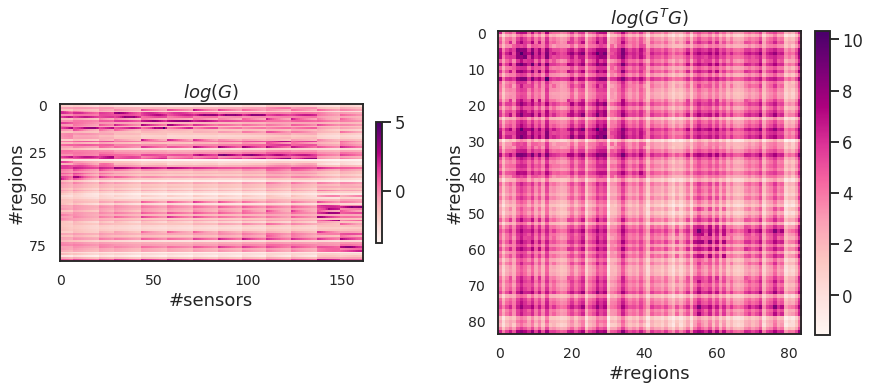

In [18]:
from matplotlib import colors, cm

plt.figure(figsize=(13,6))

plt.subplot(121)
plt.imshow(np.log(G.T),  interpolation='nearest', cmap='RdPu' )
plt.colorbar(fraction=0.046, pad=0.04, shrink=0.4)
plt.xlabel("#sensors", fontsize=18)
plt.ylabel("#regions", fontsize=18)
plt.title("$log (G)$", fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.subplot(122)
plt.imshow(np.log(Q),  interpolation='nearest', cmap='RdPu' )
plt.colorbar(fraction=0.046, pad=0.04)
plt.xlabel("#regions", fontsize=18)
plt.ylabel("#regions", fontsize=18)
plt.title("$log (G^TG)$", fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.tight_layout(pad=4)
plt.savefig(os.path.join(cwd+'/Figs',"plot_GTG.png"))
plt.show()

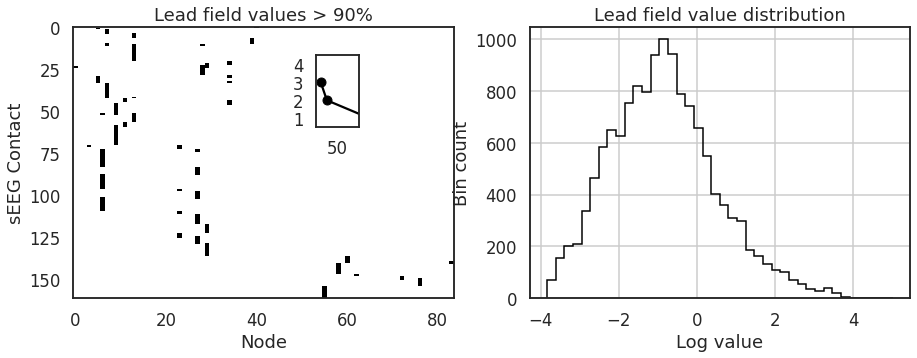

In [19]:
from matplotlib import rc
rc('image', cmap='binary', interpolation='nearest')

plt.figure(figsize=(15, 5))
plt.subplot(121)
nGr = G/G.max(axis=1)[:, newaxis] > 0.9
plt.imshow(nGr, interpolation='nearest', aspect='auto')
plt.title('Lead field values > 90%'), plt.xlabel('Node'), plt.ylabel('sEEG Contact')
a = axes([.35, .6, .04, .2])
n = bincount(nGr.sum(axis=1))
plt.plot(n[1:], np.r_[1:len(n)], 'ko-')
plt.yticks([1, 2, 3, 4]), plt.xticks([50]), plt.ylim([0.5, 4.5]), plt.xlim([-10, 110])
plt.subplot(122), plt.hist(log(G).reshape((-1,)), 40, color='k', histtype='step'), grid(1);
plt.title('Lead field value distribution'), plt.xlabel('Log value'), plt.ylabel('Bin count');

Although X(t) is driven by noise due to the stochastic formalization of Epileptor model (SDEs), here, we add observation noise to the measuremd SEEG data:

In [20]:
noise_level=0.01

In [21]:
S=Seeg+noise_level*np.random.randn(ns,nt)

In [22]:
S.shape, G.shape, X_true.shape

((162, 1200), (162, 84), (84, 1200))

Note that pseudo-inverse of matrix Q is sensitive to the level of tolerance, i.e., the cutoff for small singular values. Accordinng to numpy.linalg.pinv¶, the Singular values smaller (in modulus) than rcond * largest_singular_value (again, in modulus) are set to zero.

To get the proper tolerence value, we sweep over rcond using $np.linalg.pinv$, and we then select the min of error between $Q$ and $QQ^{-}Q$, where $Q=G^\top G$. 

In [23]:
tol=[]
Errinv=[]
sweep_range=range(30)

i=0
for e in sweep_range:
    eps=(10**(-e))
    Q_ginv = np.linalg.pinv(Q,  rcond=eps)
    tol.append(10**(-e))
    Errinv.append(np.sum((Q- np.dot(Q, np.dot(Q_ginv, Q)))**2))
    i=i=1

In [24]:
np.log(Errinv)[np.argmin(Errinv)]

-19.862845060898586

In [25]:
eps_opt = tol[np.argmin(Errinv)]
print('optimal rcond=', eps_opt)

optimal rcond= 1e-10


 The following figure shows the error between $Q=G^\top G$ and $QQ^{-}Q$, indicating that the pseudo-inverse of matrix $Q=G^\top G$ is very sensitive to the tolerance level, i.e., the cutoff for small singular values.

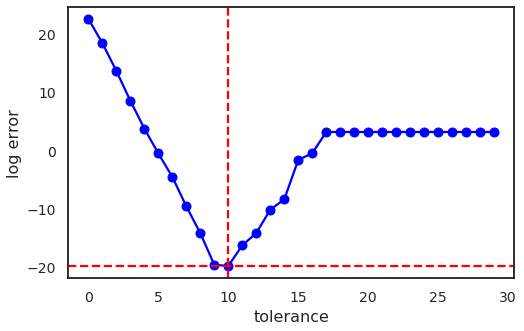

In [26]:
plt.figure(figsize=(8, 5))    
plt.plot(sweep_range, np.log(Errinv), '.b-', markersize=18)
plt.axvline(x=np.argmin(Errinv),color='red',linestyle='--')
plt.axhline(y=np.log(Errinv)[np.argmin(Errinv)],color='red',linestyle='--')
plt.xlabel("tolerance", fontsize=16)
plt.ylabel("log error", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig(os.path.join(cwd+'/Figs',"SweepTolerence.png"))
plt.show()

In [27]:
Q_ginv = np.linalg.pinv(Q,  rcond=eps_opt)

In [28]:
np.allclose(Q, np.dot(Q, np.dot(Q_ginv, Q)))   

True

In [29]:
print('error=', np.sum((Q- np.dot(Q, np.dot(Q_ginv, Q))))**2)

error= 7.352173765965567e-08


 Here, the source signal was estimated as $X_{est}=(G^\top G)^{-} G^ \top S$, where  $(G^\top G)^{-}$ is g-inverse of $G^\top G$ ( i.e., with  $Q=G^\top G$, then: $QQ^{-}Q=Q$).

In [30]:
X_est=np.dot(np.dot(Q_ginv, G.T), S)

In [31]:
X_est.shape, X_true.shape

((84, 1200), (84, 1200))

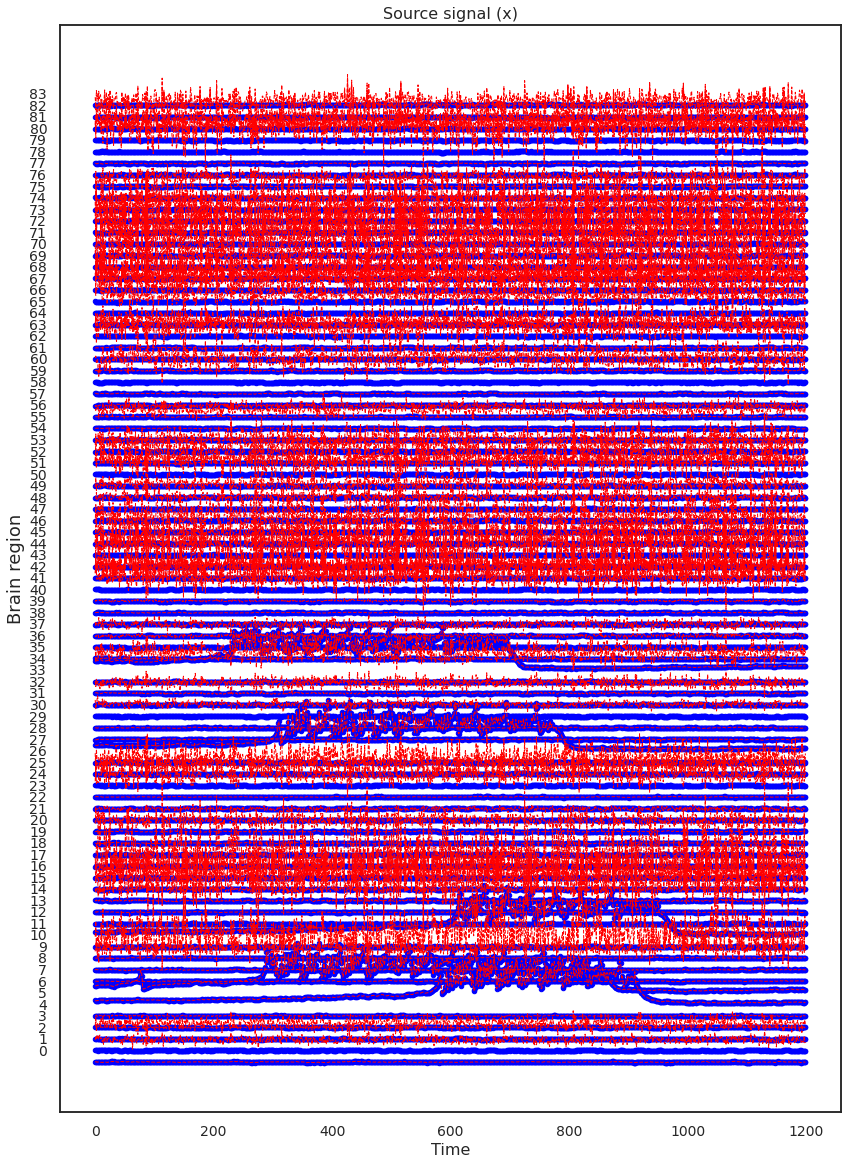

In [32]:
plt.figure(figsize=(14,20))
plt.plot(X_true.T+ np.r_[0:(nn)]+2, '.b')
plt.plot(X_est.T+ np.r_[0:(nn)]+2, 'r--', linewidth=1)
plt.yticks(np.r_[0:(nn)], np.r_[0:(nn)],fontsize=10)
plt.title("Source signal (x)",fontsize=16)
plt.xlabel('Time',fontsize=16)
plt.ylabel('Brain region',fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig(os.path.join(cwd+'/Figs',"EstimatedSourceSignals.png"))
plt.show()

In [33]:
ROI=np.array([Ez_idx[1], Pz_idx[2], 7, 50])
ROI

array([34, 27,  7, 50])

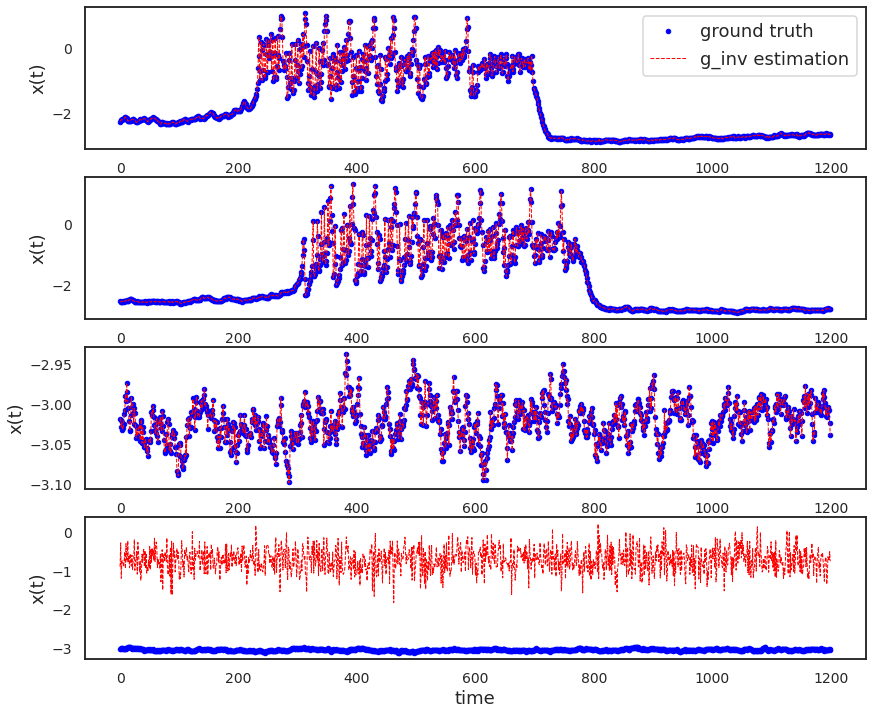

In [34]:
plt.figure(figsize=(14,12))

for i in range(len(ROI)):
    plt.subplot(len(ROI),1,i+1)
    plt.plot(X_true[ROI[i],], '.b', label='ground truth')
    plt.plot(X_est[ROI[i],], 'r--', linewidth=1, label='g_inv estimation')
    plt.ylabel('x(t)',fontsize=18)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    if i==0:
        plt.legend(fontsize=18)
    if i==(len(ROI)-1): 
       plt.xlabel('time',fontsize=18)
 
plt.savefig(os.path.join(cwd+'/Figs',"Selected_EstimatedSourceSignalsLFP_ginv.png"))
plt.show()

In [35]:
Err_per_region= np.sum((X_est-X_true)**2, axis=1)

In [36]:
print('error in source estimation=', np.sum(Err_per_region))

error in source estimation= 130519.0323746115


Note that error mainly concentrated on HZ on the right brain hemisphere where there is no electrode implantation (left focal epilepsy), i.e.,  where the gain matrix goes to zeros, equivalently,  ($G^{T}G$) is sparse.

In [37]:
print('error in source EZ estimation=', Err_per_region[Ez_idx])

error in source EZ estimation= [6.20507583e-05 2.21601819e-02]


In [38]:
print('error in source PZ estimation=', Err_per_region[Pz_idx])

error in source PZ estimation= [4.97008512e-04 6.37139663e-03 7.69912646e-05]


In [39]:
print('error in source HZ estimation=', Err_per_region[7])

error in source HZ estimation= 0.00026774572322222154


In [40]:
print('error in source HZ estimation=', Err_per_region[50])

error in source HZ estimation= 6670.298994616702


In the following we show that the error in the estimation of hidden states are mainly related to the regions which are located far from the sensors (right hemisphere in left epilepsy patient.)

# Plot region and electrode positions

Here we load the electrode "contacts" from "complex.ades"

In [41]:
contacts = []
with open(cwd+ '/ExperimentalData/PatientData/complex_raw.ades', 'r') as fd:
    for line in fd.readlines():
        parts = [p.strip() for p in line.strip().split('=')]
        if len(parts)>1 and parts[1] == 'SEEG':
            name, idx = re.match("([A-Z]+[a-z]*[']*)([0-9]+)", parts[0]).groups()
            idx = int(idx)
            contacts.append((name, idx)) 

Here we assigne the names, and xyz positions of regions and the electrodes from "centers.txt", "elecs_name.txt", respectively, and then we plot them in (x, y),  (x,z), and (y,z) coordinates.

In [42]:
reg_xyz = np.loadtxt(cwd+ '/ExperimentalData/PatientData/centers.txt', usecols=(1,2,3))
reg_names = []
with open(cwd+ '/ExperimentalData/PatientData/centers.txt', 'r') as fd:
    for i, line in enumerate(fd.readlines()):
        reg_names.append('r%03d-%s' % (i, line.strip().split()[0]))


seeg_labels = []
seeg_xyz = np.loadtxt(cwd+ '/ExperimentalData/PatientData/elecs_name.txt', usecols=(1,2,3))
with open(cwd+ '/ExperimentalData/PatientData/elecs_name.txt', 'r') as fd:
    for line in fd.readlines():
        parts = line.strip().split()
        seeg_labels.append(parts[0].upper())
monopolar_chan_to_pos = []
for name, idx in contacts:
    monopolar_chan_to_pos.append(seeg_labels.index(name+str(idx)))
seeg_xyz = np.array([seeg_xyz[i] for i in monopolar_chan_to_pos])

In [43]:
def plot_electrodes():
    x, y, z = zip(reg_xyz.T, seeg_xyz.T)
    for i, ((ra, sa), (rb, sb)) in enumerate([(x, y), (y, z), (z, x)]):
        plt.subplot(1, 3, i + 1)
        plt.scatter(sa, sb ,color='gray',marker='^', s=25)
        yy=Err_per_region
        colors = cm.seismic(yy)
        plt.scatter(ra,rb, cmap = 'rainbow', color=colors, s=50)
        plt.scatter(ra,rb, color=colors, s=.5e-2+0.05*yy)
        plt.axis([-120, 100, -120, 100])

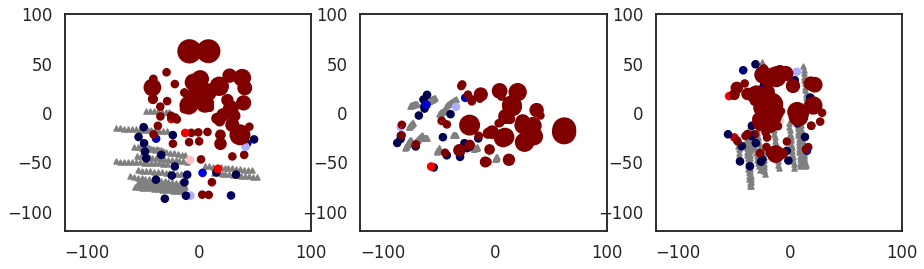

In [44]:
plt.figure(figsize=(15, 4))
plot_electrodes()
plt.savefig(os.path.join(cwd+'/Figs',"SensorSourcepng"))
plt.show()

In [45]:
elecnames=[]
electrodes = {}  
with open(cwd+ '/ExperimentalData/PatientData/elecs_name.txt', 'r') as fd:
            for i, line in enumerate(fd.readlines()):
                line = line.strip()
                contact, x, y, z = line.split()
                elecnames.append(contact)
                name, _ = re.match("([A-Za-z]+[']*)([0-9]+)", contact).groups()
                if name in electrodes:
                    electrodes[name].append(i)
                else:
                    electrodes[name] = [i]

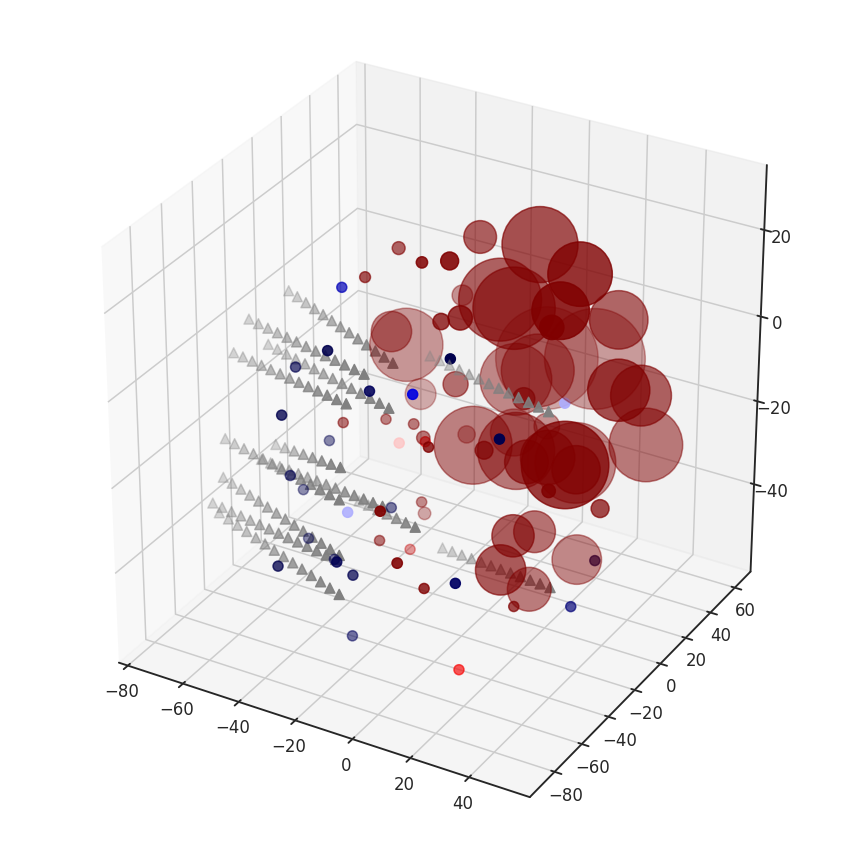

In [46]:
       fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111, projection='3d')

for name, idxs in electrodes.items():
    ax.scatter(seeg_xyz [idxs, 0], seeg_xyz [idxs, 1], seeg_xyz [idxs, 2], color='grey', marker='^', s=100)
    
y=Err_per_region
colors = cm.seismic(y)
ax.scatter(reg_xyz [:, 0], reg_xyz [:, 1], reg_xyz [:, 2], color=colors, s=100+y)
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/Figs',"SourceLocalizationErrorperRegion.png"))
plt.show()    